In [1]:
# ------------------ IMPORTS ------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torchmetrics
import wandb
import pandas as pd
import numpy as np
import time
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import shutil
import random
from pathlib import Path
from tabulate import tabulate

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn

import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 4
EPOCHS = 40
PATIENCE = 5  # For early stopping
LR = 0.0005
BATCH_SIZE = 32

print(DEVICE)

cuda


In [3]:
wandb.init(
    project="heira-test",
    config={
        "architecture": "ResNet50",
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "optimizer": "Adam"
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jj_12 (eshaan-rithesh2023-vit-chennai). Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # ImageNet normalization
])

train_dataset = ImageFolder('data/train', transform=transform)
val_dataset = ImageFolder('data/val', transform=transform)
class_names = train_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
print(len(train_dataset.classes))

4


In [5]:
# === DATA LOADERS ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
train_data = ImageFolder("data/train", transform=transform)
val_data = ImageFolder("data/val", transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

#Model
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE) #use cuda

# === LOSS & OPTIMIZER ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

/home/joseph/anaconda3/envs/plantLeafDisease/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/joseph/anaconda3/envs/plantLeafDisease/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# === WANDB WATCH ===
wandb.watch(model, log="gradients", log_freq=100)

# === EARLY STOPPING ===
best_val_loss = float('inf')
patience_counter = 0

# === TRAINING LOOP ===
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        wandb.log({"batch_loss": loss.item(), "epoch": epoch})

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    # === LOG TO WANDB ===
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss / len(train_loader),
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    # === CONFUSION MATRIX (Correct WandB Format) ===
    pred_table = wandb.Table(columns=["ground_truth", "prediction"])
    for gt, pred in zip(all_labels, all_preds):
        pred_table.add_data(class_names[gt], class_names[pred])

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_labels,
        preds=all_preds,
        class_names=class_names
    )})

    # OR if that still shows plain text, use this instead:
    wandb.log({"conf_mat_table": pred_table})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=class_names
    )})

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    wandb.log({
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"]
    })

    # Optionally log per-class metrics too
    for class_name in class_names:
        wandb.log({
            f"{class_name}_precision": report[class_name]["precision"],
            f"{class_name}_recall": report[class_name]["recall"],
            f"{class_name}_f1": report[class_name]["f1-score"]
    })
    
    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        wandb.run.summary["best_val_loss"] = best_val_loss
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/40 | Train Loss: 47.2781 | Val Loss: 0.5918 | Val Acc: 90.09%
Epoch 2/40 | Train Loss: 23.3323 | Val Loss: 0.3469 | Val Acc: 95.64%
Epoch 3/40 | Train Loss: 15.5858 | Val Loss: 0.2585 | Val Acc: 95.90%
Epoch 4/40 | Train Loss: 12.7760 | Val Loss: 0.2063 | Val Acc: 96.96%
Epoch 5/40 | Train Loss: 9.8620 | Val Loss: 0.1715 | Val Acc: 97.09%
Epoch 6/40 | Train Loss: 8.2138 | Val Loss: 0.1474 | Val Acc: 97.62%
Epoch 7/40 | Train Loss: 7.8674 | Val Loss: 0.1393 | Val Acc: 97.36%
Epoch 8/40 | Train Loss: 6.4886 | Val Loss: 0.1322 | Val Acc: 97.09%
Epoch 9/40 | Train Loss: 6.1961 | Val Loss: 0.1149 | Val Acc: 97.36%
Epoch 10/40 | Train Loss: 5.6375 | Val Loss: 0.1051 | Val Acc: 98.02%
Epoch 11/40 | Train Loss: 5.3738 | Val Loss: 0.1041 | Val Acc: 98.15%
Epoch 12/40 | Train Loss: 4.9468 | Val Loss: 0.0968 | Val Acc: 97.89%


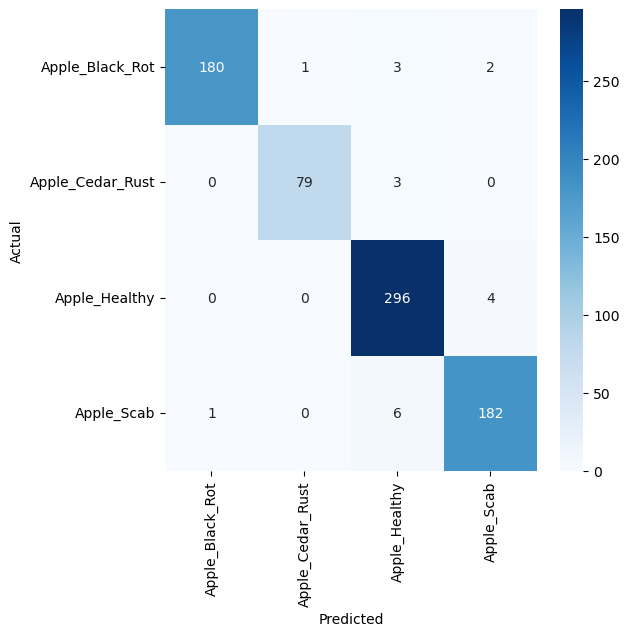

In [9]:

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
wandb.log({"conf_matrix_img": wandb.Image(fig)})